## Process weather data

In [1]:
import os
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import Purples_9
from palettable.colorbrewer.sequential import GnBu_8
from palettable.colorbrewer.sequential import OrRd_6

from ideotype.weafile_process import (read_wea,
                                      read_solrad,
                                      wea_combine,
                                      wea_preprocess,
                                      wea_siteyears,
                                      wea_filter,
                                      make_weafile,
                                      wea_summarize)
from ideotype import DATA_PATH

In [2]:
# Read in stations info
fpaths_wea = os.path.join(DATA_PATH, 'files', 'filepaths_wea.yml')
with open(fpaths_wea) as pfile:
    dict_fpaths = yaml.safe_load(pfile)

# Read in info on conversion between WBAN & USAF id numbering system
fpath_stations_info = os.path.join(DATA_PATH,
                                   *dict_fpaths['stations_info'])
df_stations = pd.read_csv(fpath_stations_info, dtype={'USAF': str})

In [3]:
%%time
basepath = '/home/disk/eos8/ach315/upscale/weadata/process'
df_temp, df_rh, df_precip, df_solrad = wea_preprocess(basepath)

CPU times: user 31.2 s, sys: 7.42 s, total: 38.7 s
Wall time: 39.2 s


### USDA-NIFA proposal site-years

In [4]:
%%time
gseason_start = 3
gseason_end = 10
crthr = 2
siteyears = wea_siteyears(df_temp, df_rh, df_precip, df_solrad, 
                          gseason_start, gseason_end, crthr)
print('siteyears:', len(siteyears))

siteyears: 3927
CPU times: user 2min 41s, sys: 1.82 s, total: 2min 43s
Wall time: 2min 43s


siteyears: 2563
sites: 115
CPU times: user 3.77 s, sys: 69.6 ms, total: 3.84 s
Wall time: 4.03 s


Text(-108, 22, 'siteyears: 2563')

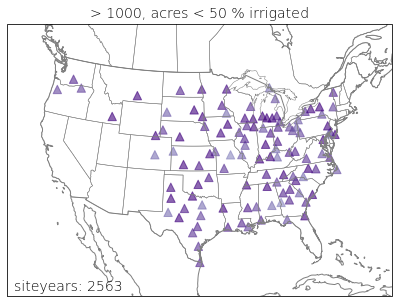

In [5]:
%%time
# Total number of site-years
# Filtered based on: area planted, percent irrigated, & total available years of data
# Values used for USDA-NIFA proposal
area = 1000/2.47  # acres converted into ha
irri = 50
yearspersite = 15

# ---------------------------
siteyears_filtered = wea_filter(siteyears, area, irri, yearspersite)
print('siteyears:', siteyears_filtered.shape[0])

# Total number of sites
df_siteyears = pd.DataFrame(siteyears_filtered.groupby('site').count())
print('sites:', df_siteyears.shape[0])

# Merge site-years info with stations info
df = pd.merge(df_siteyears, df_stations, left_on='site', right_on='USAF')

# Map out simulation sites
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df['NSRDB_LON(dd)'], df['NSRDB_LAT (dd)'],
           transform=ccrs.PlateCarree(), s=70, marker='^',
           c=df.year, cmap=Purples_9.mpl_colormap, alpha=0.6,
           vmin=1, vmax=25)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'> {int(area*2.47)}, acres < {irri} % irrigated',
             fontweight='light', fontsize=14)
ax.text(-108, 22, f'siteyears: {siteyears_filtered.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=14)

In [14]:
%%time
outpath = '/home/disk/eos8/ach315/upscale/weadata/data/nifa'
make_weafile(
    siteyears_filtered, df_temp, df_rh, df_precip, df_solrad, outpath)

CPU times: user 22min 10s, sys: 10.3 s, total: 22min 20s
Wall time: 22min 21s


### Manuscript site-years

In [4]:
%%time
# First cut at site-years
gseason_start = 2
gseason_end = 11
crthr = 2
siteyears = wea_siteyears(df_temp, df_rh, df_precip, df_solrad, 
                          gseason_start, gseason_end, crthr)
print('siteyears:', len(siteyears))

siteyears: 3201
CPU times: user 2min 31s, sys: 1.05 s, total: 2min 32s
Wall time: 2min 32s


siteyears_filtered: 1177
sites: 61
CPU times: user 3.73 s, sys: 17.1 ms, total: 3.75 s
Wall time: 4 s


Text(-108, 22, 'siteyears: 1177')

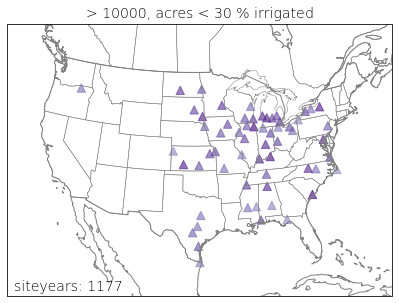

In [5]:
%%time
# Further filter based on: area planted, percent irrigated, & total available years of data
# Values used for USDA-NIFA proposal
area = 10000/2.47  # acres converted into ha
irri = 30
yearspersite = 15

# ---------------------------
siteyears_filtered = wea_filter(siteyears, area, irri, yearspersite)
print('siteyears_filtered:', siteyears_filtered.shape[0])

# Total number of sites
df_siteyears = pd.DataFrame(siteyears_filtered.groupby('site').count())
print('sites:', df_siteyears.shape[0])

# Merge site-years info with stations info
df = pd.merge(df_siteyears, df_stations, left_on='site', right_on='USAF')

# Map out simulation sites
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df['NSRDB_LON(dd)'], df['NSRDB_LAT (dd)'],
           transform=ccrs.PlateCarree(), s=70, marker='^',
           c=df.year, cmap=Purples_9.mpl_colormap, alpha=0.6,
           vmin=1, vmax=25)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'> {int(area*2.47)}, acres < {irri} % irrigated',
             fontweight='light', fontsize=14)
ax.text(-108, 22, f'siteyears: {siteyears_filtered.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=14)

(array([ 9., 10.,  4.,  8., 11.,  6.,  6.,  4.,  1.,  2.]),
 array([15. , 16.1, 17.2, 18.3, 19.4, 20.5, 21.6, 22.7, 23.8, 24.9, 26. ]),
 <BarContainer object of 10 artists>)

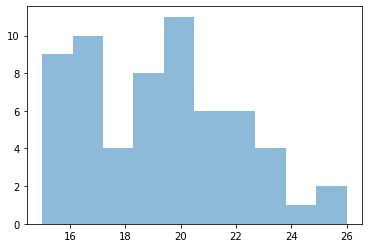

In [6]:
plt.hist(list(siteyears_filtered.groupby('site').count().year), alpha=0.5)

In [7]:
%%time
outpath = '/home/disk/eos8/ach315/upscale/weadata/data/test/'
make_weafile(
    siteyears_filtered, df_temp, df_rh, df_precip, df_solrad, outpath)

CPU times: user 11min 39s, sys: 1.04 s, total: 11min 40s
Wall time: 11min 43s


### Weather data summary

In [7]:
%%time
gseason_start = 3
gseason_end = 10

df_wea_summary = wea_summarize(siteyears_filtered,
                               df_temp, df_rh, df_precip, df_solrad,
                               gseason_start, gseason_end)

CPU times: user 7min 27s, sys: 5.08 s, total: 7min 32s
Wall time: 7min 32s


In [8]:
df_wea_all = df_wea_summary.groupby('site').mean()
df_wea_all = pd.merge(df_wea_all, df_stations, left_on='site', right_on='USAF')

Text(-108, 22, 'siteyears: 1177')

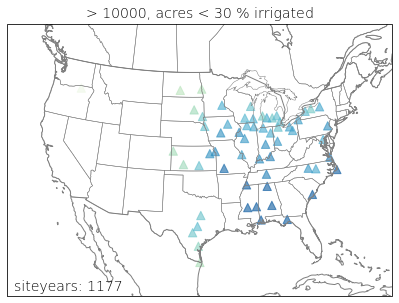

In [9]:
# Map out simulation sites
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_wea_all['NSRDB_LON(dd)'], df_wea_all['NSRDB_LAT (dd)'],
           transform=ccrs.PlateCarree(), s=70, marker='^',
           c=df_wea_all.precip, cmap=GnBu_8.mpl_colormap, 
           vmin=100, vmax=800, alpha=0.6)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'> {int(area*2.47)}, acres < {irri} % irrigated',
             fontweight='light', fontsize=14)
ax.text(-108, 22, f'siteyears: {siteyears_filtered.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=14)

Text(-108, 22, 'siteyears: 1177')

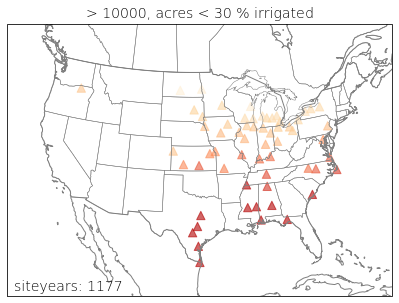

In [18]:
from palettable.colorbrewer.sequential import GnBu_8

# Map out simulation sites
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_wea_all['NSRDB_LON(dd)'], df_wea_all['NSRDB_LAT (dd)'],
           transform=ccrs.PlateCarree(), s=70, marker='^',
           c=df_wea_all.temp, cmap=OrRd_6.mpl_colormap, 
           vmax=22, alpha=0.6)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title(f'> {int(area*2.47)}, acres < {irri} % irrigated',
             fontweight='light', fontsize=14)
ax.text(-108, 22, f'siteyears: {siteyears_filtered.shape[0]}',
        horizontalalignment='right', transform=ccrs.PlateCarree(),
        fontweight='light', fontsize=14)